In [2]:
%autoreload 2

In [18]:
from collections import defaultdict
from argparse import Namespace
import copy
import gzip
import itertools
import os
import pickle
import sys
import typing

import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *

In [4]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


In [5]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,1.00,...,0.975856,0.984382,0.970248,0.981414,0.981920,0.983617,0.919078,0.915602,0.974574,0.987096
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,1.00,...,0.985632,0.986181,0.966645,0.978594,0.977472,0.984273,0.921563,0.931860,0.945369,0.962067
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,0.00,...,0.975984,0.980604,0.000000,0.000000,0.000000,0.000000,0.844787,0.858832,0.923039,0.942307
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,0.00,...,0.986042,0.985931,0.000000,0.000000,0.000000,0.000000,0.919078,0.915602,0.974574,0.987096
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0.25,...,0.984624,0.983172,0.000000,0.000000,0.000000,0.000000,0.976741,0.978090,0.970715,0.987147


In [8]:
evo_sampler = typing.cast(PopulationBasedSampler, utils.load_data('2023_04_27_1', 'samples', 'evo_sampler_microbial_ga'))

AttributeError: Can't get attribute 'EnergyFunctionFitnessWrapper' on <module '__main__'>

In [23]:
def plot_sampler_fitness_trajectory(evo: PopulationBasedSampler, title: typing.Optional[str] = None, axsize: typing.Tuple[int, int] = (8, 6),
                                    plot_diversity: typing.Optional[bool] = None,
                                    min_real_game_fitness: float =  74.9304, max_real_game_fitness: float = 80.0098):
    
    if plot_diversity is None:
        plot_diversity = hasattr(evo, 'diversity_metrics_history') and len(evo.diversity_metrics_history) > 0
            
    layout = (1, 2) if plot_diversity else (1, 1)
    figsize = (axsize[0] * layout[1], axsize[1])

    fig, axes = plt.subplots(*layout, figsize=figsize)

    mean, max_fit, std = [], [], []
    for step_dict in evo.fitness_metrics_history:
        mean.append(step_dict['mean'])
        max_fit.append(step_dict['max'])
        std.append(step_dict['std'])

    mean = np.array(mean)
    max_fit = np.array(max_fit)
    std = np.array(std)

    fitness_ax = typing.cast(matplotlib.axes.Axes, axes[0] if plot_diversity else axes)

    fitness_ax.plot(mean, label='mean fitness')
    fitness_ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2, label='std')  # type; ignore
    fitness_ax.plot(max_fit, label='max fitness')

    fitness_ax.hlines(min_real_game_fitness, 0, len(mean), label='min real game fitness', color='black', ls='--')
    fitness_ax.hlines(max_real_game_fitness, 0, len(mean), label='max real game fitness', color='black', ls='--')

    fitness_ax.set_xlabel('Generation')
    fitness_ax.set_ylabel('Fitness')

    fitness_ax.legend(loc='best')
    
    if plot_diversity:
        mean_div, min_div, max_div, std_div = [], [], [], []
        for step_dict in evo.diversity_metrics_history:
            mean_div.append(step_dict['mean'])
            min_div.append(step_dict['min'])
            max_div.append(step_dict['max'])
            std_div.append(step_dict['std'])

        mean_div = np.array(mean_div)
        min_div = np.array(min_div)
        max_div = np.array(max_div)
        std_div = np.array(std_div)

        diversity_ax = typing.cast(matplotlib.axes.Axes, axes[1])
        diversity_ax.plot(mean_div, label='mean diversity')
        diversity_ax.fill_between(np.arange(len(mean_div)), mean_div - std_div, mean_div + std_div, alpha=0.2, label='std')  # type: ignore
        diversity_ax.plot(min_div, label='min diversity')
        diversity_ax.plot(max_div, label='max diversity')

        diversity_ax.set_xlabel('Generation')
        diversity_ax.set_ylabel('Diversity')

        diversity_ax.legend(loc='best')
        
    if title is not None:
        if plot_diversity:
            plt.suptitle(title)
        else:
            plt.title(title)

    plt.show()


# plot_sampler_fitness_trajectory(evo_sampler, 'Microbial GA')

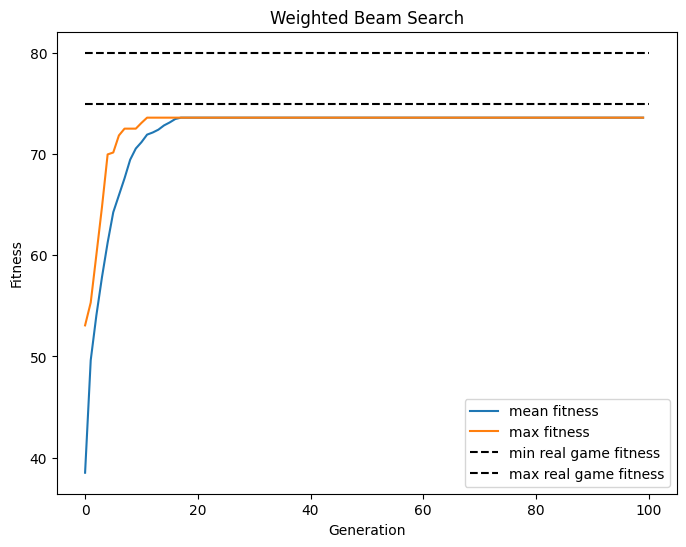

In [ ]:
beam_sampler = typing.cast(PopulationBasedSampler, utils.load_data('2023_04_27', 'samples', 'evo_sampler_weighted_beam'))
plot_sampler_fitness_trajectory(beam_sampler, 'Weighted Beam Search')

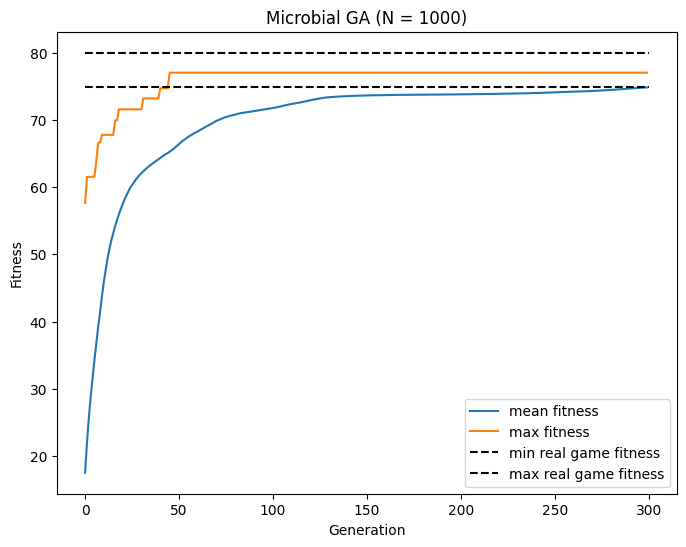

In [12]:
evo_sampler_pop_1000 = typing.cast(PopulationBasedSampler, utils.load_data('2023_04_28', 'samples', 'evo_sampler_microbial_ga'))
plot_sampler_fitness_trajectory(evo_sampler_pop_1000, 'Microbial GA (N = 1000)')

In [39]:
evo_sampler_pop_1000.visualize_top_sample(100, postprocess_sample=True)

### Energy of visualized game: -75.430

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                         |
|----------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| mean_depth_scoring_2: **0.751** = (1.000) * 0.751                          | ast_ngram_full_n_7_score: **-26.024** = (0.893) * -29.148                        |
| max_number_variables_types_quantified_types_1: **0.738** = (1.000) * 0.738 | ast_ngram_constraints_n_7_score: **-20.892** = (0.977) * -21.388                 |
| on_arg_types_furniture_balls_constraints: **0.311** = (1.000) * 0.311      | all_variables_used: **-5.121** = (1.000) * -5.121                                |
| mean_depth_constraints_0: **0.159** = (1.000) * 0.159                      | all_preferences_used: **-4.585** = (1.000) * -4.585                              |
| max_depth_constraints_0: **0.007** = (1.000) * 0.007                       | ast_ngram_scoring_n_5_score: **-3.531** = (0.929) * -3.801                       |
|                                                                            | all_variables_defined: **-2.156** = (1.000) * -2.156                             |
|                                                                            | mean_depth_setup_0: **-2.025** = (1.000) * -2.025                                |
|                                                                            | max_depth_setup_0: **-1.956** = (1.000) * -1.956                                 |
|                                                                            | node_count_setup_0: **-1.848** = (1.000) * -1.848                                |
|                                                                            | section_doesnt_exist_setup: **-1.837** = (1.000) * -1.837                        |
|                                                                            | max_depth_scoring_2: **-1.025** = (1.000) * -1.025                               |
|                                                                            | mean_depth_terminal_0: **-0.917** = (1.000) * -0.917                             |
|                                                                            | max_depth_terminal_0: **-0.906** = (1.000) * -0.906                              |
|                                                                            | max_quantification_count_setup_0: **-0.857** = (1.000) * -0.857                  |
|                                                                            | max_number_variables_types_quantified_variables_1: **-0.771** = (1.000) * -0.771 |
|                                                                            | section_doesnt_exist_terminal: **-0.761** = (1.000) * -0.761                     |
|                                                                            | node_count_terminal_0: **-0.703** = (1.000) * -0.703                             |
|                                                                            | node_count_constraints_0: **-0.547** = (1.000) * -0.547                          |
|                                                                            | node_count_scoring_2: **-0.516** = (1.000) * -0.516                              |
|                                                                            | max_quantification_count_constraints_1: **-0.428** = (1.000) * -0.428            |

### Game:

```pddl
(define (game evo-963-963) (:domain few-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - dodgeball)
        (at-end
          (on bed ?v0)
        )
      )
    )
  )
)
(:scoring
  (* 5 (count preference0) (count preference0) (count preference0) )
)
)
```

In [41]:
ast = copy.deepcopy(game_asts[0])

In [42]:
from ast_utils import replace_child

In [45]:
replace_child(ast[1], ['game_name'], 'test')

In [48]:
import ast_printer

In [50]:
s = ast_printer.ast_to_string(ast)

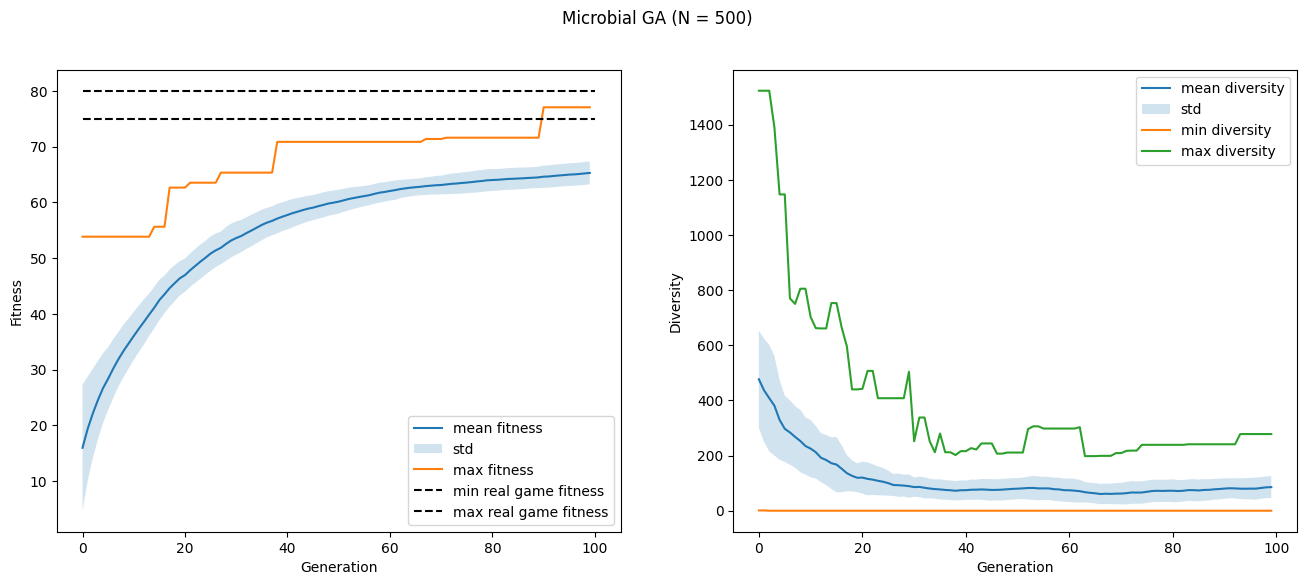

In [24]:
evo_sampler_pop_500_diversity = typing.cast(PopulationBasedSampler, utils.load_data('2023_05_01', 'samples/every_gen', 'evo_sampler_microbial_ga_gen_99'))
plot_sampler_fitness_trajectory(evo_sampler_pop_500_diversity, 'Microbial GA (N = 500)')

In [34]:
gen = 0
n_best = 10
evo_sampler_diversity = typing.cast(PopulationBasedSampler, utils.load_data('2023_05_01', 'samples/every_gen', f'evo_sampler_microbial_ga_gen_{gen}'))

for i in range(1, n_best + 1):
    evo_sampler_diversity.visualize_top_sample(i, postprocess_sample=True)


### Energy of visualized game: -53.826

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                         |
|----------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| pref_forall_used_incorrect: **6.136** = (1.000) * 6.136                    | ast_ngram_full_n_7_score: **-16.559** = (0.568) * -29.148                        |
| max_number_variables_types_quantified_types_1: **0.738** = (1.000) * 0.738 | ast_ngram_constraints_n_7_score: **-15.606** = (0.730) * -21.388                 |
| max_depth_scoring_4: **0.424** = (1.000) * 0.424                           | all_variables_used: **-5.121** = (1.000) * -5.121                                |
| mean_depth_constraints_0: **0.159** = (1.000) * 0.159                      | all_preferences_used: **-4.585** = (1.000) * -4.585                              |
| max_depth_constraints_0: **0.007** = (1.000) * 0.007                       | ast_ngram_scoring_n_5_score: **-2.930** = (0.771) * -3.801                       |
|                                                                            | all_variables_defined: **-2.156** = (1.000) * -2.156                             |
|                                                                            | mean_depth_setup_0: **-2.025** = (1.000) * -2.025                                |
|                                                                            | max_depth_setup_0: **-1.956** = (1.000) * -1.956                                 |
|                                                                            | node_count_setup_0: **-1.848** = (1.000) * -1.848                                |
|                                                                            | section_doesnt_exist_setup: **-1.837** = (1.000) * -1.837                        |
|                                                                            | mean_depth_terminal_0: **-0.917** = (1.000) * -0.917                             |
|                                                                            | max_depth_terminal_0: **-0.906** = (1.000) * -0.906                              |
|                                                                            | max_quantification_count_setup_0: **-0.857** = (1.000) * -0.857                  |
|                                                                            | max_number_variables_types_quantified_variables_1: **-0.771** = (1.000) * -0.771 |
|                                                                            | section_doesnt_exist_terminal: **-0.761** = (1.000) * -0.761                     |
|                                                                            | node_count_terminal_0: **-0.703** = (1.000) * -0.703                             |
|                                                                            | node_count_constraints_0: **-0.547** = (1.000) * -0.547                          |
|                                                                            | node_count_scoring_2: **-0.516** = (1.000) * -0.516                              |
|                                                                            | max_quantification_count_constraints_1: **-0.428** = (1.000) * -0.428            |
|                                                                            | mean_depth_scoring_4: **-0.257** = (1.000) * -0.257                              |

### Game:

```pddl
(define (game evo-148-148) (:domain few-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - block)
        (at-end
          (agent_holds ?v0)
        )
      )
    )
  )
)
(:scoring
  (* 180 (* (+ (count-once preference0:blue_pyramid_block) 9 10 )
      (count preference0:basketball:green)
    )
  )
)
)
```

### Energy of visualized game: -49.233

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                          | Features decreasing energy (= more real)                                         |
|-----------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| repeated_variables_found: **4.956** = (1.000) * 4.956                             | ast_ngram_full_n_7_score: **-17.208** = (0.590) * -29.148                        |
| max_depth_scoring_1: **0.929** = (1.000) * 0.929                                  | ast_ngram_constraints_n_7_score: **-14.753** = (0.690) * -21.388                 |
| length_of_then_modals_3: **0.913** = (1.000) * 0.913                              | all_preferences_used: **-4.585** = (1.000) * -4.585                              |
| max_number_variables_types_quantified_types_1: **0.738** = (1.000) * 0.738        | ast_ngram_scoring_n_5_score: **-3.752** = (0.987) * -3.801                       |
| on_arg_types_large_objects_large_objects_constraints: **0.584** = (1.000) * 0.584 | all_variables_defined: **-2.156** = (1.000) * -2.156                             |
| node_count_scoring_0: **0.318** = (1.000) * 0.318                                 | mean_depth_setup_0: **-2.025** = (1.000) * -2.025                                |
| mean_depth_constraints_0: **0.159** = (1.000) * 0.159                             | max_depth_setup_0: **-1.956** = (1.000) * -1.956                                 |
| node_count_constraints_1: **0.103** = (1.000) * 0.103                             | node_count_setup_0: **-1.848** = (1.000) * -1.848                                |
| no_adjacent_same_modal: **0.060** = (-1.000) * -0.060                             | section_doesnt_exist_setup: **-1.837** = (1.000) * -1.837                        |
| predicate_under_modal_once_on: **0.035** = (1.000) * 0.035                        | mean_depth_scoring_1: **-1.116** = (1.000) * -1.116                              |
|                                                                                   | mean_depth_terminal_0: **-0.917** = (1.000) * -0.917                             |
|                                                                                   | max_depth_terminal_0: **-0.906** = (1.000) * -0.906                              |
|                                                                                   | max_quantification_count_setup_0: **-0.857** = (1.000) * -0.857                  |
|                                                                                   | max_number_variables_types_quantified_variables_1: **-0.771** = (1.000) * -0.771 |
|                                                                                   | section_doesnt_exist_terminal: **-0.761** = (1.000) * -0.761                     |
|                                                                                   | max_depth_constraints_1: **-0.732** = (1.000) * -0.732                           |
|                                                                                   | node_count_terminal_0: **-0.703** = (1.000) * -0.703                             |
|                                                                                   | predicate_under_modal_hold_in_motion: **-0.529** = (1.000) * -0.529              |
|                                                                                   | max_quantification_count_constraints_1: **-0.428** = (1.000) * -0.428            |
|                                                                                   | in_motion_arg_types_large_objects_constraints: **-0.197** = (1.000) * -0.197     |

### Game:

```pddl
(define (game evo-475-475) (:domain few-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - dodgeball ?v1 - hexagonal_bin ?v2 - teddy_bear)
        (then
          (once (on ?v2 ?v2) )
          (hold (above ?v2 ?v2) )
          (hold (in_motion ?v2) )
        )
      )
    )
  )
)
(:scoring
  (count preference0)
)
)
```

### Energy of visualized game: -48.803

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                         |
|----------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| pref_forall_used_incorrect: **6.136** = (1.000) * 6.136                    | ast_ngram_full_n_7_score: **-16.347** = (0.561) * -29.148                        |
| repeated_variables_found: **4.956** = (1.000) * 4.956                      | ast_ngram_constraints_n_7_score: **-15.526** = (0.726) * -21.388                 |
| max_depth_scoring_1: **0.929** = (1.000) * 0.929                           | all_variables_used: **-5.121** = (1.000) * -5.121                                |
| max_number_variables_types_quantified_types_1: **0.738** = (1.000) * 0.738 | all_preferences_used: **-4.585** = (1.000) * -4.585                              |
| max_depth_terminal_2: **0.629** = (1.000) * 0.629                          | ast_ngram_scoring_n_5_score: **-3.277** = (0.862) * -3.801                       |
| node_count_scoring_0: **0.318** = (1.000) * 0.318                          | ast_ngram_terminal_n_5_score: **-2.791** = (0.892) * -3.128                      |
| node_count_terminal_2: **0.193** = (1.000) * 0.193                         | all_variables_defined: **-2.156** = (1.000) * -2.156                             |
| mean_depth_constraints_0: **0.159** = (1.000) * 0.159                      | mean_depth_setup_0: **-2.025** = (1.000) * -2.025                                |
| max_depth_constraints_0: **0.007** = (1.000) * 0.007                       | max_depth_setup_0: **-1.956** = (1.000) * -1.956                                 |
|                                                                            | node_count_setup_0: **-1.848** = (1.000) * -1.848                                |
|                                                                            | section_doesnt_exist_setup: **-1.837** = (1.000) * -1.837                        |
|                                                                            | in_arg_types_any_object_any_object_constraints: **-1.475** = (1.000) * -1.475    |
|                                                                            | mean_depth_scoring_1: **-1.116** = (1.000) * -1.116                              |
|                                                                            | max_quantification_count_setup_0: **-0.857** = (1.000) * -0.857                  |
|                                                                            | max_number_variables_types_quantified_variables_1: **-0.771** = (1.000) * -0.771 |
|                                                                            | node_count_constraints_0: **-0.547** = (1.000) * -0.547                          |
|                                                                            | max_quantification_count_constraints_1: **-0.428** = (1.000) * -0.428            |
|                                                                            | mean_depth_terminal_2: **-0.213** = (1.000) * -0.213                             |

### Game:

```pddl
(define (game evo-59-59) (:domain medium-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - game_object)
        (at-end
          (in ?v0 ?v0)
        )
      )
    )
  )
)
(:terminal
  (>= (count preference0:beachball) 100 )
)
(:scoring
  (count-once-per-objects preference0:dodgeball)
)
)
```

### Energy of visualized game: -48.732

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                         |
|----------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| pref_forall_used_incorrect: **6.136** = (1.000) * 6.136                    | ast_ngram_full_n_7_score: **-17.477** = (0.600) * -29.148                        |
| repeated_variables_found: **4.956** = (1.000) * 4.956                      | ast_ngram_constraints_n_7_score: **-16.763** = (0.784) * -21.388                 |
| node_count_scoring_1: **1.053** = (1.000) * 1.053                          | all_variables_used: **-5.121** = (1.000) * -5.121                                |
| mean_depth_scoring_2: **0.751** = (1.000) * 0.751                          | all_preferences_used: **-4.585** = (1.000) * -4.585                              |
| max_number_variables_types_quantified_types_1: **0.738** = (1.000) * 0.738 | ast_ngram_scoring_n_5_score: **-3.121** = (0.821) * -3.801                       |
| on_arg_types_blocks_blocks_constraints: **0.617** = (1.000) * 0.617        | ast_ngram_terminal_n_5_score: **-3.030** = (0.969) * -3.128                      |
| node_count_terminal_2: **0.193** = (1.000) * 0.193                         | all_variables_defined: **-2.156** = (1.000) * -2.156                             |
| mean_depth_constraints_0: **0.159** = (1.000) * 0.159                      | mean_depth_setup_0: **-2.025** = (1.000) * -2.025                                |
| mean_depth_terminal_1: **0.128** = (1.000) * 0.128                         | max_depth_setup_0: **-1.956** = (1.000) * -1.956                                 |
| max_depth_terminal_1: **0.067** = (1.000) * 0.067                          | node_count_setup_0: **-1.848** = (1.000) * -1.848                                |
| max_depth_constraints_0: **0.007** = (1.000) * 0.007                       | section_doesnt_exist_setup: **-1.837** = (1.000) * -1.837                        |
|                                                                            | max_depth_scoring_2: **-1.025** = (1.000) * -1.025                               |
|                                                                            | max_quantification_count_setup_0: **-0.857** = (1.000) * -0.857                  |
|                                                                            | max_number_variables_types_quantified_variables_1: **-0.771** = (1.000) * -0.771 |
|                                                                            | node_count_constraints_0: **-0.547** = (1.000) * -0.547                          |
|                                                                            | max_quantification_count_constraints_1: **-0.428** = (1.000) * -0.428            |

### Game:

```pddl
(define (game evo-121-121) (:domain many-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - block)
        (at-end
          (on ?v0 ?v0)
        )
      )
    )
  )
)
(:terminal
  (>= (total-score) 4 )
)
(:scoring
  (* 4 (count-once preference0:golfball) )
)
)
```

### Energy of visualized game: -46.890

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                         |
|----------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| two_number_operation_found: **4.276** = (1.000) * 4.276                    | ast_ngram_constraints_n_7_score: **-15.211** = (0.711) * -21.388                 |
| nested_logicals_found: **2.406** = (1.000) * 2.406                         | ast_ngram_full_n_7_score: **-14.141** = (0.485) * -29.148                        |
| node_count_scoring_1: **1.053** = (1.000) * 1.053                          | all_variables_used: **-5.121** = (1.000) * -5.121                                |
| max_number_variables_types_quantified_types_1: **0.738** = (1.000) * 0.738 | ast_ngram_scoring_n_5_score: **-2.754** = (0.725) * -3.801                       |
| section_without_pref_or_total_count_scoring: **0.293** = (1.000) * 0.293   | all_variables_defined: **-2.156** = (1.000) * -2.156                             |
| mean_depth_constraints_0: **0.159** = (1.000) * 0.159                      | mean_depth_setup_0: **-2.025** = (1.000) * -2.025                                |
|                                                                            | max_depth_setup_0: **-1.956** = (1.000) * -1.956                                 |
|                                                                            | node_count_setup_0: **-1.848** = (1.000) * -1.848                                |
|                                                                            | section_doesnt_exist_setup: **-1.837** = (1.000) * -1.837                        |
|                                                                            | mean_depth_scoring_1: **-1.116** = (1.000) * -1.116                              |
|                                                                            | max_depth_scoring_2: **-1.025** = (1.000) * -1.025                               |
|                                                                            | mean_depth_terminal_0: **-0.917** = (1.000) * -0.917                             |
|                                                                            | max_depth_terminal_0: **-0.906** = (1.000) * -0.906                              |
|                                                                            | max_quantification_count_setup_0: **-0.857** = (1.000) * -0.857                  |
|                                                                            | max_number_variables_types_quantified_variables_1: **-0.771** = (1.000) * -0.771 |
|                                                                            | section_doesnt_exist_terminal: **-0.761** = (1.000) * -0.761                     |
|                                                                            | max_depth_constraints_1: **-0.732** = (1.000) * -0.732                           |
|                                                                            | node_count_terminal_0: **-0.703** = (1.000) * -0.703                             |
|                                                                            | node_count_constraints_0: **-0.547** = (1.000) * -0.547                          |
|                                                                            | max_quantification_count_constraints_1: **-0.428** = (1.000) * -0.428            |

### Game:

```pddl
(define (game evo-390-390) (:domain many-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - tan_cube_block)
        (at-end
          (not
            (not
              (agent_holds ?v0)
            )
          )
        )
      )
    )
  )
)
(:scoring
  (* 8 10 (+ 3 2 )
  )
)
)
```

### Energy of visualized game: -46.800

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                         |
|----------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| pref_forall_used_incorrect: **6.136** = (1.000) * 6.136                    | ast_ngram_full_n_7_score: **-16.850** = (0.578) * -29.148                        |
| in_arg_types_other_constraints: **3.698** = (1.000) * 3.698                | ast_ngram_constraints_n_7_score: **-12.481** = (0.584) * -21.388                 |
| node_count_scoring_1: **1.053** = (1.000) * 1.053                          | all_variables_used: **-5.121** = (1.000) * -5.121                                |
| mean_depth_scoring_2: **0.751** = (1.000) * 0.751                          | all_preferences_used: **-4.585** = (1.000) * -4.585                              |
| max_number_variables_types_quantified_types_1: **0.738** = (1.000) * 0.738 | ast_ngram_scoring_n_5_score: **-3.577** = (0.941) * -3.801                       |
| mean_depth_constraints_0: **0.159** = (1.000) * 0.159                      | all_variables_defined: **-2.156** = (1.000) * -2.156                             |
| max_depth_constraints_0: **0.007** = (1.000) * 0.007                       | mean_depth_setup_0: **-2.025** = (1.000) * -2.025                                |
|                                                                            | max_depth_setup_0: **-1.956** = (1.000) * -1.956                                 |
|                                                                            | node_count_setup_0: **-1.848** = (1.000) * -1.848                                |
|                                                                            | section_doesnt_exist_setup: **-1.837** = (1.000) * -1.837                        |
|                                                                            | max_depth_scoring_2: **-1.025** = (1.000) * -1.025                               |
|                                                                            | mean_depth_terminal_0: **-0.917** = (1.000) * -0.917                             |
|                                                                            | max_depth_terminal_0: **-0.906** = (1.000) * -0.906                              |
|                                                                            | max_quantification_count_setup_0: **-0.857** = (1.000) * -0.857                  |
|                                                                            | max_number_variables_types_quantified_variables_1: **-0.771** = (1.000) * -0.771 |
|                                                                            | section_doesnt_exist_terminal: **-0.761** = (1.000) * -0.761                     |
|                                                                            | node_count_terminal_0: **-0.703** = (1.000) * -0.703                             |
|                                                                            | node_count_constraints_0: **-0.547** = (1.000) * -0.547                          |
|                                                                            | max_quantification_count_constraints_1: **-0.428** = (1.000) * -0.428            |

### Game:

```pddl
(define (game evo-340-340) (:domain medium-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - (either hexagonal_bin))
        (at-end
          (in rug ?v0)
        )
      )
    )
  )
)
(:scoring
  (* 2 (count preference0:golfball) )
)
)
```

### Energy of visualized game: -44.459

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                         |
|----------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| pref_forall_used_incorrect: **6.136** = (1.000) * 6.136                    | ast_ngram_full_n_7_score: **-13.388** = (0.459) * -29.148                        |
| distance_arg_types_other_constraints: **3.387** = (1.000) * 3.387          | ast_ngram_constraints_n_7_score: **-12.436** = (0.581) * -21.388                 |
| max_depth_scoring_1: **0.929** = (1.000) * 0.929                           | all_variables_used: **-5.121** = (1.000) * -5.121                                |
| max_number_variables_types_quantified_types_1: **0.738** = (1.000) * 0.738 | all_preferences_used: **-4.585** = (1.000) * -4.585                              |
| mean_depth_constraints_1: **0.389** = (1.000) * 0.389                      | ast_ngram_scoring_n_5_score: **-3.183** = (0.837) * -3.801                       |
| node_count_scoring_0: **0.318** = (1.000) * 0.318                          | all_variables_defined: **-2.156** = (1.000) * -2.156                             |
|                                                                            | mean_depth_setup_0: **-2.025** = (1.000) * -2.025                                |
|                                                                            | max_depth_setup_0: **-1.956** = (1.000) * -1.956                                 |
|                                                                            | node_count_setup_0: **-1.848** = (1.000) * -1.848                                |
|                                                                            | section_doesnt_exist_setup: **-1.837** = (1.000) * -1.837                        |
|                                                                            | mean_depth_scoring_1: **-1.116** = (1.000) * -1.116                              |
|                                                                            | mean_depth_terminal_0: **-0.917** = (1.000) * -0.917                             |
|                                                                            | max_depth_terminal_0: **-0.906** = (1.000) * -0.906                              |
|                                                                            | max_quantification_count_setup_0: **-0.857** = (1.000) * -0.857                  |
|                                                                            | max_number_variables_types_quantified_variables_1: **-0.771** = (1.000) * -0.771 |
|                                                                            | section_doesnt_exist_terminal: **-0.761** = (1.000) * -0.761                     |
|                                                                            | max_depth_constraints_1: **-0.732** = (1.000) * -0.732                           |
|                                                                            | node_count_terminal_0: **-0.703** = (1.000) * -0.703                             |
|                                                                            | node_count_constraints_0: **-0.547** = (1.000) * -0.547                          |
|                                                                            | max_quantification_count_constraints_1: **-0.428** = (1.000) * -0.428            |

### Game:

```pddl
(define (game evo-192-192) (:domain many-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - beachball)
        (at-end
          (and
            (in_motion ?v0)
            (>= (distance rug ?v0) (distance side_table ?v0))
          )
        )
      )
    )
  )
)
(:scoring
  (count preference0:hexagonal_bin)
)
)
```

### Energy of visualized game: -44.415

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                         |
|----------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| pref_forall_used_incorrect: **6.136** = (1.000) * 6.136                    | ast_ngram_constraints_n_7_score: **-15.643** = (0.731) * -21.388                 |
| max_depth_scoring_1: **0.929** = (1.000) * 0.929                           | ast_ngram_full_n_7_score: **-13.258** = (0.455) * -29.148                        |
| max_number_variables_types_quantified_types_1: **0.738** = (1.000) * 0.738 | all_preferences_used: **-4.585** = (1.000) * -4.585                              |
| max_depth_terminal_2: **0.629** = (1.000) * 0.629                          | ast_ngram_scoring_n_5_score: **-3.183** = (0.837) * -3.801                       |
| length_of_then_modals_1: **0.356** = (1.000) * 0.356                       | all_variables_defined: **-2.156** = (1.000) * -2.156                             |
| node_count_scoring_0: **0.318** = (1.000) * 0.318                          | mean_depth_setup_0: **-2.025** = (1.000) * -2.025                                |
| node_count_terminal_2: **0.193** = (1.000) * 0.193                         | ast_ngram_terminal_n_5_score: **-2.002** = (0.640) * -3.128                      |
| mean_depth_constraints_0: **0.159** = (1.000) * 0.159                      | max_depth_setup_0: **-1.956** = (1.000) * -1.956                                 |
|                                                                            | node_count_setup_0: **-1.848** = (1.000) * -1.848                                |
|                                                                            | section_doesnt_exist_setup: **-1.837** = (1.000) * -1.837                        |
|                                                                            | mean_depth_scoring_1: **-1.116** = (1.000) * -1.116                              |
|                                                                            | max_quantification_count_setup_0: **-0.857** = (1.000) * -0.857                  |
|                                                                            | max_number_variables_types_quantified_variables_1: **-0.771** = (1.000) * -0.771 |
|                                                                            | max_depth_constraints_1: **-0.732** = (1.000) * -0.732                           |
|                                                                            | node_count_constraints_0: **-0.547** = (1.000) * -0.547                          |
|                                                                            | predicate_under_modal_hold_in_motion: **-0.529** = (1.000) * -0.529              |
|                                                                            | max_quantification_count_constraints_1: **-0.428** = (1.000) * -0.428            |
|                                                                            | mean_depth_terminal_2: **-0.213** = (1.000) * -0.213                             |
|                                                                            | in_motion_arg_types_large_objects_constraints: **-0.197** = (1.000) * -0.197     |

### Game:

```pddl
(define (game evo-351-351) (:domain few-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - chair ?v1 - teddy_bear)
        (then
          (hold (in_motion ?v1) )
        )
      )
    )
  )
)
(:terminal
  (> (count-unique-positions preference0:blue_pyramid_block) 10 )
)
(:scoring
  (count preference0:hexagonal_bin)
)
)
```

### Energy of visualized game: -43.359

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                         |
|----------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| pref_forall_used_incorrect: **6.136** = (1.000) * 6.136                    | ast_ngram_constraints_n_7_score: **-16.128** = (0.754) * -21.388                 |
| two_number_operation_found: **4.276** = (1.000) * 4.276                    | ast_ngram_full_n_7_score: **-14.065** = (0.483) * -29.148                        |
| agent_holds_arg_types_any_object_constraints: **1.186** = (1.000) * 1.186  | all_variables_used: **-5.121** = (1.000) * -5.121                                |
| max_depth_scoring_1: **0.929** = (1.000) * 0.929                           | all_preferences_used: **-4.585** = (1.000) * -4.585                              |
| max_number_variables_types_quantified_types_1: **0.738** = (1.000) * 0.738 | ast_ngram_terminal_n_5_score: **-2.389** = (0.764) * -3.128                      |
| section_without_pref_or_total_count_terminal: **0.453** = (1.000) * 0.453  | all_variables_defined: **-2.156** = (1.000) * -2.156                             |
| node_count_scoring_0: **0.318** = (1.000) * 0.318                          | ast_ngram_scoring_n_5_score: **-2.128** = (0.560) * -3.801                       |
| node_count_terminal_2: **0.193** = (1.000) * 0.193                         | mean_depth_setup_0: **-2.025** = (1.000) * -2.025                                |
| mean_depth_constraints_0: **0.159** = (1.000) * 0.159                      | max_depth_setup_0: **-1.956** = (1.000) * -1.956                                 |
| mean_depth_terminal_1: **0.128** = (1.000) * 0.128                         | node_count_setup_0: **-1.848** = (1.000) * -1.848                                |
| max_depth_terminal_1: **0.067** = (1.000) * 0.067                          | section_doesnt_exist_setup: **-1.837** = (1.000) * -1.837                        |
| max_depth_constraints_0: **0.007** = (1.000) * 0.007                       | mean_depth_scoring_1: **-1.116** = (1.000) * -1.116                              |
|                                                                            | max_quantification_count_setup_0: **-0.857** = (1.000) * -0.857                  |
|                                                                            | max_number_variables_types_quantified_variables_1: **-0.771** = (1.000) * -0.771 |
|                                                                            | node_count_constraints_0: **-0.547** = (1.000) * -0.547                          |
|                                                                            | max_quantification_count_constraints_1: **-0.428** = (1.000) * -0.428            |

### Game:

```pddl
(define (game evo-0-75-0) (:domain few-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - game_object)
        (at-end
          (agent_holds ?v0)
        )
      )
    )
  )
)
(:terminal
  (>= 3 4 )
)
(:scoring
  (count-longest preference0:pink_dodgeball)
)
)
```

### Energy of visualized game: -40.979

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                         |
|----------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| pref_forall_used_incorrect: **6.136** = (1.000) * 6.136                    | ast_ngram_constraints_n_7_score: **-16.466** = (0.770) * -21.388                 |
| disjoint_seq_funcs_found: **3.982** = (1.000) * 3.982                      | ast_ngram_full_n_7_score: **-13.068** = (0.448) * -29.148                        |
| in_motion_arg_types_agent_constraints: **2.642** = (1.000) * 2.642         | all_variables_used: **-5.121** = (1.000) * -5.121                                |
| node_count_scoring_1: **1.053** = (1.000) * 1.053                          | all_preferences_used: **-4.585** = (1.000) * -4.585                              |
| mean_depth_terminal_4: **0.975** = (1.000) * 0.975                         | ast_ngram_scoring_n_5_score: **-2.669** = (0.702) * -3.801                       |
| length_of_then_modals_3: **0.913** = (1.000) * 0.913                       | all_variables_defined: **-2.156** = (1.000) * -2.156                             |
| mean_depth_scoring_2: **0.751** = (1.000) * 0.751                          | mean_depth_setup_0: **-2.025** = (1.000) * -2.025                                |
| max_number_variables_types_quantified_types_1: **0.738** = (1.000) * 0.738 | max_depth_setup_0: **-1.956** = (1.000) * -1.956                                 |
| mean_depth_constraints_1: **0.389** = (1.000) * 0.389                      | node_count_setup_0: **-1.848** = (1.000) * -1.848                                |
| max_depth_terminal_4: **0.286** = (1.000) * 0.286                          | section_doesnt_exist_setup: **-1.837** = (1.000) * -1.837                        |
| predicate_under_modal_once_in_motion: **0.120** = (1.000) * 0.120          | predicate_under_modal_once_agent_holds: **-1.114** = (1.000) * -1.114            |
| starts_and_ends_once: **0.009** = (1.000) * 0.009                          | max_depth_scoring_2: **-1.025** = (1.000) * -1.025                               |
|                                                                            | ast_ngram_terminal_n_5_score: **-0.915** = (0.292) * -3.128                      |
|                                                                            | max_quantification_count_setup_0: **-0.857** = (1.000) * -0.857                  |
|                                                                            | max_number_variables_types_quantified_variables_1: **-0.771** = (1.000) * -0.771 |
|                                                                            | max_depth_constraints_1: **-0.732** = (1.000) * -0.732                           |
|                                                                            | predicate_under_modal_hold_agent_holds: **-0.686** = (1.000) * -0.686            |
|                                                                            | node_count_constraints_0: **-0.547** = (1.000) * -0.547                          |
|                                                                            | max_quantification_count_constraints_1: **-0.428** = (1.000) * -0.428            |
|                                                                            | node_count_terminal_3: **-0.106** = (1.000) * -0.106                             |

### Game:

```pddl
(define (game evo-9-9) (:domain medium-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - cube_block)
        (then
          (once (in_motion agent) )
          (hold (agent_holds ?v0) )
          (once (not (agent_holds ?v0) ) )
        )
      )
    )
  )
)
(:terminal
  (or
    (>= (* 2 (count preference0:hexagonal_bin:dodgeball) 10 )
      (count preference0:doggie_bed)
    )
    (> (total-score) (count-once-per-objects preference0:green) )
  )
)
(:scoring
  (* (count-once-per-objects preference0) (count preference0:yellow) 4 )
)
)
```

In [45]:
sampler = ASTSampler(evo_sampler_pop_500_diversity.grammar_parser, evo_sampler_pop_500_diversity.counter, seed=0,
                     omit_rules=['at_end'])

evo_sampler_pop_500_diversity.initial_sampler.sampler = sampler

In [50]:
s = evo_sampler_pop_500_diversity.initial_sampler.sample()
e = evo_sampler_pop_500_diversity._score_proposal(s)
print(e)
print(ast_printer.ast_to_string(s, '\n'))

28.85328483581543
(define (game game-id-510) (:domain medium-objects-room-v1)
(:constraints
  (and
    (preference binKnockedOver
      (exists (?o3 - (either pillow))
        (then
          (once (agent_holds ?o3) )
          (hold-while (in_motion ?o3) (in_motion desk) )
          (once (and (touch ?o3 ?o3) (on ?o3 ?o3) ) )
        )
      )
    )
  )
)
(:terminal
  (>= 1 50 )
)
(:scoring
  (* 6 10 (+ (count binKnockedOver:dodgeball) 5 )
  )
)
)


In [39]:
evo_sampler_pop_500_diversity.samplers[0].rules['pref_body_exists']

{'exists_vars': {'options': 'variable_list',
  'rule_posterior': {'variable_list': 1.0},
  'type_posterior': {'rule': 1.0, 'token': 0.0}},
 'exists_args': {'options': ['then', 'at_end'],
  'rule_posterior': {'then': 0.8042328042328042,
   'at_end': 0.19576719576719576},
  'type_posterior': {'rule': 1.0, 'token': 0.0}},
 'production': [('token', '(exists'),
  ('named', 'exists_vars'),
  ('named', 'exists_args'),
  ('token', ')')]}

In [40]:
sampler = ASTSampler(evo_sampler_pop_500_diversity.grammar_parser, evo_sampler_pop_500_diversity.counter, seed=0,
                     omit_rules=['at_end'])

In [41]:
sampler.rules['pref_body_exists']

{'exists_vars': {'options': 'variable_list',
  'rule_posterior': {'variable_list': 1.0},
  'type_posterior': {'rule': 1.0, 'token': 0.0}},
 'exists_args': {'options': ['then', 'at_end'],
  'rule_posterior': {'then': 1.0},
  'type_posterior': {'rule': 1.0, 'token': 0.0}},
 'production': [('token', '(exists'),
  ('named', 'exists_vars'),
  ('named', 'exists_args'),
  ('token', ')')]}